In [ ]:
import spacy 
import re 
import pandas as pd
from spacy.lang.en import English
from collections import Counter
from itertools import chain
import ahocorasick
import ast
from analysis.occ_frequency.clean_data import get_occupations_list_en, get_occupations_list
from spacy.lang.de import German
from spacy.lang.it import Italian
from spacy.lang.es import Spanish 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from operator import itemgetter

/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/my_venv/lib64/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
de_female_df_redo = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/redo/de_female_occ_full_data.csv', encoding="utf-8")

In [4]:
print(de_female_df.columns)

Index(['Unnamed: 0', 'wikidata_code', 'title', 'intro', 'gender',
       'occupations', 'first_sentence', 'named_entities',
       'overlapping_occupations_male',
       'overlapping_occupations_sentence1_male',
       'overlapping_occupations_female',
       'overlapping_occupations_sentence1_female'],
      dtype='object')


In [4]:
def new_german_analysis(df):
    #Want to: 
    # 1. Split up german occupation titles list into two lists: one token occupations and multi token
    # 2. For one token occupations, want to find matches (in first sentence) with hard word boundaries (like in german code)
    # 3. For multi token occupations, want to just look up matches 
    # 4. Want to remove named entities from matched tokens in that line 
    # 5. Want to get final matched titles list 
    df['intro'] = df['intro'].astype(str)
    df['first_sentence'] = df['first_sentence'].astype(str)
    df['named_entities'] = df['named_entities'].apply(ast.literal_eval)
    df['named_entities'] = df['named_entities'].apply(lambda x: [item.casefold() for item in x])
    df['overlapping_occupations_sentence1_female'] = df['overlapping_occupations_sentence1_female'].apply(ast.literal_eval)
    df['overlapping_occupations_sentence1_male'] = df['overlapping_occupations_sentence1_male'].apply(ast.literal_eval)
    print("hello")
    print(df['named_entities'].head(10))
    
    def filter_NER(row):
        col1_counts = Counter(row['overlapping_occupations_sentence1_male'])  # Count occurrences in col1
        col2_counts = Counter(row['named_entities'])  # Count occurrences in col2

        # Remove only up to the number of times they appear in col2
        for word, count in col2_counts.items():
            if word in col1_counts:
                col1_counts[word] -= count  # Reduce count but not below zero
                if col1_counts[word] <= 0:
                    del col1_counts[word]  # Remove word if count reaches zero

        # Reconstruct the filtered list based on updated counts
        filtered_list = []
        for word, count in col1_counts.items():
            filtered_list.extend([word] * count)  # Add back only remaining occurrences

        return filtered_list
    df['overlapping_occupations_sentence1_male'] = df.apply(
    lambda row: [item for item in row['overlapping_occupations_sentence1_male'] if item != row['title']],
    axis=1
)

    def remove_geborene(row):
    # Find all words that are preceded by "geborene"
        geborene_matches = re.findall(r'geborene\s+(\w+)', row['first_sentence'])
        # Remove those words from the list
        return [item for item in row['overlapping_occupations_sentence1_male'] if item not in geborene_matches]
    
    def filter_male_names(row):
        return [item for item in row['overlapping_occupations_sentence1_male']
            if all(item not in s for s in row['named_entities'])]
    # remove named entities from matched occupations
    df['overlapping_occupations_sentence1_male'] = df.apply(filter_NER, axis=1)
    df['overlapping_occupations_sentence1_male'] = df.apply(remove_geborene, axis=1)
    df['overlapping_occupations_sentence1_male'] = df.apply(filter_male_names, axis=1)
    # df['overlapping_occupations_sentence1_female'] = df.apply(filter_NER, axis=1)
    # print(df['overlapping_occupations_sentence1_female'].head(10))
    filtered_df = df[df['overlapping_occupations_sentence1_male'].apply(lambda x: 'müller' in x)]
    print(filtered_df.head())

In [6]:
new_german_analysis(de_female_df_redo)
def uppercase(text):
    text2 = [w.capitalize() for w in text]
    return text2
de_female_df_redo['overlapping_occupations_sentence1_female'] = de_female_df_redo['overlapping_occupations_sentence1_female'].apply(uppercase)
overlapping_occ_counts_s1_female_all = Counter(chain.from_iterable(de_female_df_redo['overlapping_occupations_sentence1_female']))
overlapping_occ_counts_s1_female_all_male = Counter(chain.from_iterable(de_female_df_redo['overlapping_occupations_sentence1_male']))
print(overlapping_occ_counts_s1_female_all)
print(overlapping_occ_counts_s1_female_all_male)
occ_titles_found_female = de_female_df_redo[de_female_df_redo['overlapping_occupations_sentence1_female'].map(len)>0]
print(de_female_df_redo.shape[0])
print(occ_titles_found_female.shape[0])

hello
0    [emmi, agathe, karola, margarete, wiltraut, ru...
1    [sylvia, bayr-klimpfinger, wien, österreich-un...
2                 [ulrike, scheel, dortmund, deutsche]
3                             [renee, goddard, berlin]
4    [elisabeth, lange, höppner, detmold, hamburg, ...
5      [isabella, kossina, wien, österreichische, spö]
6    [florina, gillnik, königswinter, florentine, e...
7    [christina, kauschke, dortmund, philipps-unive...
8    [noémi, ferenczy, szentendre, österreich-ungar...
9                  [sonja, gerstner, berlin, deutsche]
Name: named_entities, dtype: object
       Unnamed: 0 wikidata_code                  title  \
4905         4916       Q116323          sandra studer   
10362       10388      Q1332607  elly-viola nahmmacher   
22055       22117      Q1596524            maria röder   
25294       25361      Q1662976         ingelore lohse   
34400       34500      Q1866464            livia kádár   

                                                   intro  g

In [7]:
def make_plot1(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:20])
    print(ten_items)
    plt.bar(range(len(ten_items)), list(ten_items.values()), align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Occurences of Occupation Titles in German Female Data")
    plt.show()

In [34]:
def make_plot(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:31])
    ten_items.pop('Geistlicher', None)
    ten_items.pop('Ehefrau', None)
    print(ten_items)
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), averages, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Percentage of Occupational Title Occurences in German Female Data")
    plt.show()

In [28]:
de_male_df_redo = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/redo/de_male_occ_full_data.csv', encoding="utf-8")

In [29]:
new_german_analysis(de_male_df_redo)
def uppercase(text):
    text2 = [w.capitalize() for w in text]
    return text2
de_male_df_redo['overlapping_occupations_sentence1_male'] = de_male_df_redo['overlapping_occupations_sentence1_male'].apply(uppercase)
overlapping_occ_counts_s1_male_all = Counter(chain.from_iterable(de_male_df_redo['overlapping_occupations_sentence1_male']))
overlapping_occ_counts_s1_male_all_female = Counter(chain.from_iterable(de_male_df_redo['overlapping_occupations_sentence1_female']))
print(overlapping_occ_counts_s1_male_all)
print(overlapping_occ_counts_s1_male_all_female)
occ_titles_found_male = de_male_df_redo[de_male_df_redo['overlapping_occupations_sentence1_male'].map(len)>0]
print(de_male_df_redo.shape[0])
print(occ_titles_found_male.shape[0])

hello
0    [rolf, kniffka, brilon-wald, deutscher, bundes...
1    [horace, wells, hartford, vermont, new, york, ...
2                      [mircea, moldovan, rumänischer]
3            [robert, de, umfraville, earl, of, angus]
4    [karl, von, normann, franzburg, braunschweig, ...
5    [johann, barthold, niemeier, niemayer, niemeye...
6    [emilio, josé, bonifacio, del, rosario, santo,...
7    [paulin, nuotclà, scuol, schweizer, bündnerrom...
8    [william, earl, dodge, hartford, connecticut, ...
9    [kurt, tucholsky, berlin, göteborg, deutscher,...
Name: named_entities, dtype: object
       Unnamed: 0 wikidata_code                           title  \
2269         2274       Q499677      andreas mylius (politiker)   
5318         5326      Q2561883      werner lange (unternehmer)   
5913         5922      Q1048027                 caspar schippel   
45325       45400      Q1695484  johann mayer (politiker, 1858)   
55537       55632        Q88724          karl müller (theologe)   

     

In [10]:
interesting_occ_title_list = ['Krankenpfleger', 'Krankenpflegerin', 'Krankenschwester',"Pfleger","Pflegerin",'Sekretärin', 'Assistenz','Putzfrau', 'Reinigungskraft', 'Putzhilfe','Zimmermädchen', 'Zimmerservice','Kindergärtnerin', 'Erzieher', 'Erzieherin']
interesting_occ_title_list2 = ['Krankenpfleger', 'Krankenpflegerin', 'Krankenschwester',"Pflegerin", 
                               'Kindergärtnerin', 'Erzieher', 'Erzieherin']
lowercase_list = [item.lower() for item in interesting_occ_title_list]
de_female_df_redo['first_sentence'] = de_female_df_redo['first_sentence'].astype(str)
automaton = ahocorasick.Automaton()
for id, term in enumerate(lowercase_list):
    automaton.add_word(term, (term))
automaton.make_automaton()
def find_terms(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches

def uppercase(text):
    text2 = [w.capitalize() for w in text]
    return text2
de_female_df_redo['gendered_titles'] = de_female_df_redo['first_sentence'].apply(find_terms)
de_female_df_redo['gendered_titles'] = de_female_df_redo['gendered_titles'].apply(uppercase)
overlapping_occ_counts_female_interesting= Counter(chain.from_iterable(de_female_df_redo['gendered_titles']))

In [37]:
print(overlapping_occ_counts_female_interesting)

Counter({'Krankenschwester': 139, 'Erzieherin': 54, 'Kindergärtnerin': 38, 'Krankenpflegerin': 21, 'Pflegerin': 6})


{'Krankenschwester': 139, 'Erzieherin': 54, 'Kindergärtnerin': 38, 'Sekretärin': 36, 'Krankenpflegerin': 21, 'Pflegerin': 6, 'Pfleger': 3, 'Zimmermädchen': 1, 'Assistenz': 1}


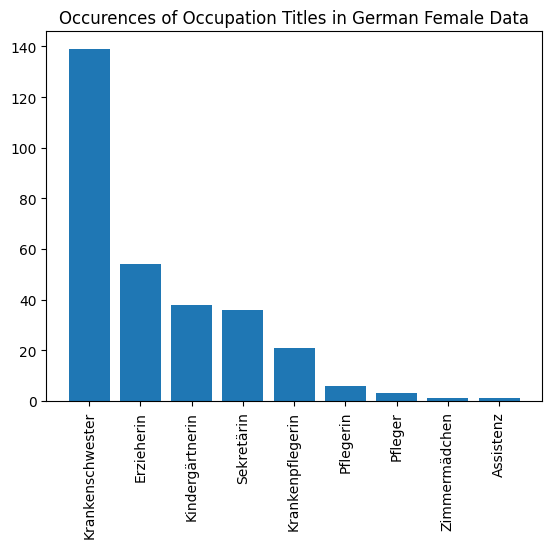

In [11]:
make_plot1(overlapping_occ_counts_female_interesting)

{'Krankenschwester': 139, 'Erzieherin': 54, 'Kindergärtnerin': 38, 'Krankenpflegerin': 21, 'Pflegerin': 6}


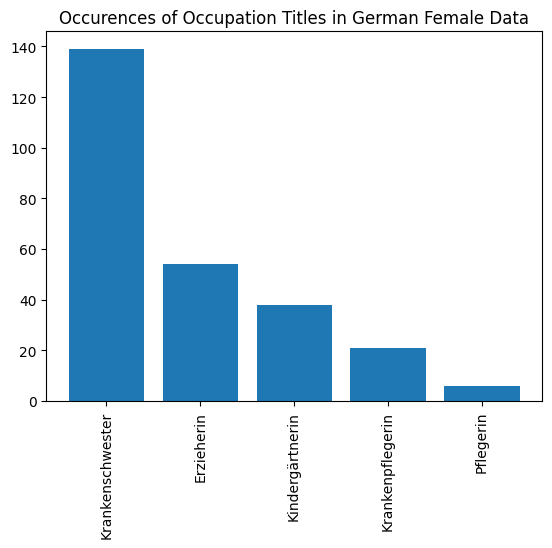

In [38]:
make_plot1(overlapping_occ_counts_female_interesting)

In [11]:
interesting_occ_title_list = ['Krankenpfleger', 'Krankenpflegerin', 'Krankenschwester',"Pfleger","Pflegerin",'Hebamme', 'Geburtshelfer', 'Geburtshelferin', 'Geburtshelfende','Sekretärin', 'Assistenz','Putzfrau', 'Reinigungskraft', 'Putzhilfe','Zimmermädchen', 'Zimmerservice']
interesting_occ_title_list2 = ['Krankenpfleger', 'Krankenpflegerin', 'Krankenschwester',"Pfleger","Pflegerin",'Hebamme', 'Geburtshelfer', 'Geburtshelferin', 
                              'Geburtshelfende','Sekretärin', 'Assistenz','Putzfrau', 'Reinigungskraft', 'Putzhilfe','Zimmermädchen', 'Zimmerservice', 'Kindergärtnerin', 'Erzieher', 'Erzieherin', 'Entbindungspfleger','Entbindungspflegerin']
lowercase_list = [item.lower() for item in interesting_occ_title_list2]
de_male_df_redo['first_sentence'] = de_male_df_redo['first_sentence'].astype(str)
automaton = ahocorasick.Automaton()
for id, term in enumerate(lowercase_list):
    automaton.add_word(term, (term))
automaton.make_automaton()
def find_terms(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches

de_male_df_redo['gendered_titles'] = de_male_df_redo['first_sentence'].apply(find_terms)
overlapping_occ_counts_male_interesting= Counter(chain.from_iterable(de_male_df_redo['gendered_titles']))
print(overlapping_occ_counts_male_interesting)

Counter({'geburtshelfer': 42, 'erzieher': 32, 'pfleger': 10, 'krankenpfleger': 2})


{'geburtshelfer': 42, 'pfleger': 10, 'krankenpfleger': 2}


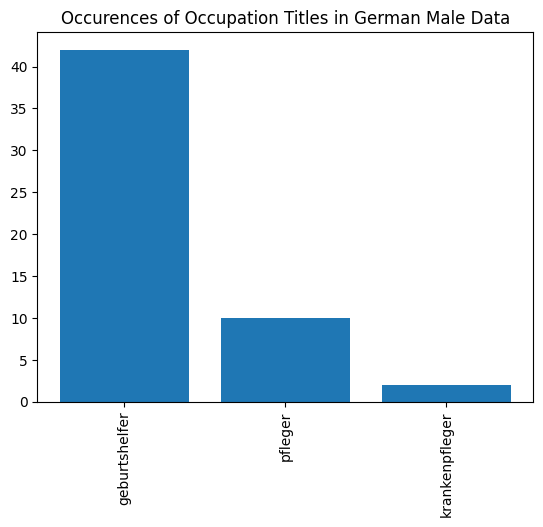

In [15]:
make_plot1(overlapping_occ_counts_male_interesting)

{'Schauspielerin': 16443, 'Politikerin': 9123, 'Schriftstellerin': 6532, 'Sängerin': 5583, 'Autorin': 4056, 'Journalistin': 2708, 'Fussballspielerin': 2404, 'Malerin': 2071, 'Badmintonspielerin': 1889, 'Tennisspielerin': 1623, 'Leichtathletin': 1620, 'Künstlerin': 1591, 'Opernsängerin': 1507, 'Komponistin': 1317, 'Prinzessin': 1287, 'Model': 1265, 'Drehbuchautorin': 1167, 'Regisseurin': 1136, 'Professorin': 1080, 'Synchronsprecherin': 1040, 'Biathletin': 992, 'Übersetzerin': 985, 'Filmschauspielerin': 975, 'Pianistin': 948, 'Songwriterin': 928, 'Historikerin': 861, 'Juristin': 850, 'Sprinterin': 844, 'Tänzerin': 833, 'Moderatorin': 816}
74474.0
[0.22078846308778902, 0.12249912721218144, 0.08770846201358863, 0.07496575986250235, 0.05446195987861536, 0.036361683272014396, 0.03227972178209845, 0.027808362650052366, 0.025364556758063216, 0.021792840454386765]


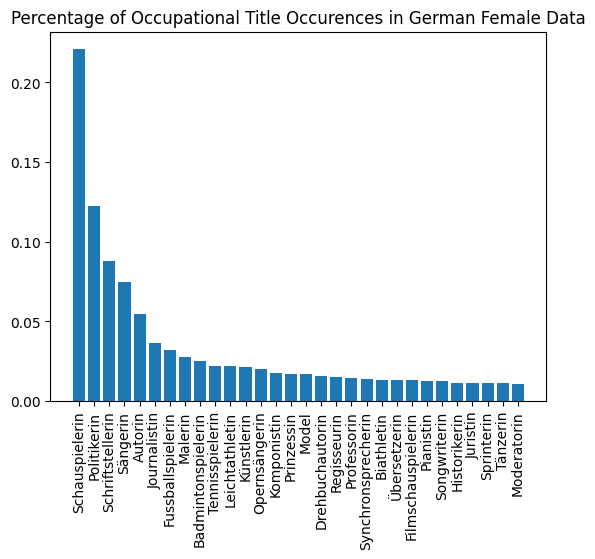

In [ ]:

make_plot(overlapping_occ_counts_s1_female_all)

{'Politiker': 13522, 'Fussballspieler': 7248, 'Schauspieler': 3992, 'Schriftsteller': 3701, 'Komponist': 3250, 'Maler': 2853, 'Jurist': 2486, 'Autor': 2484, 'Journalist': 1946, 'Hochschullehrer': 1901, 'Eishockeyspieler': 1889, 'Bischof': 1769, 'Theologe': 1704, 'Historiker': 1594, 'Professor': 1507, 'Trainer': 1500, 'Architekt': 1433, 'Unternehmer': 1385, 'Diplomat': 1336, 'Musiker': 1336, 'Sänger': 1239, 'Drehbuchautor': 1220, 'Mathematiker': 1113, 'Regisseur': 1063, 'Bildhauer': 1023, 'Radrennfahrer': 921, 'Offizier': 901, 'Dichter': 863, 'Arzt': 856, 'Physiker': 839}
68874.0
[0.19632952928536168, 0.10523564770450387, 0.05796091413305456, 0.05373580741644162, 0.04718761796904492, 0.041423468943287745, 0.03609489792955252, 0.03606585939541772, 0.028254493713157358, 0.02760112669512443]


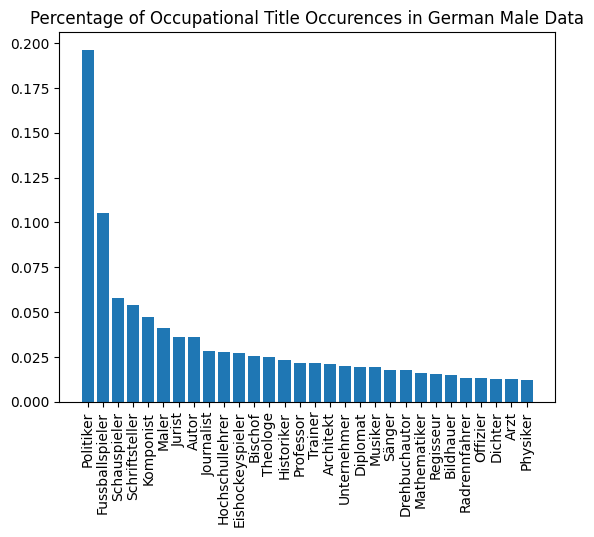

In [ ]:

make_plot(overlapping_occ_counts_s1_male_all)